# Experimentacion

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
from tqdm import tqdm

In [65]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [66]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

./../codigo/build/ContarPalabras


### Multithreading en maximo paralelo con distribucion uniforme

In [122]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in tqdm(range(20)):
    #create output file
    result = './results/uniformeRandomized.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/uniformeRandomized.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp = dfExp.drop(['sec', 'ns'], axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result)

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  30.312091  2.469228
1            1           maximoParalelo   0.271052  0.137247
2            2  cargarMultiplesArchivos  29.423984  2.518140
3            2           maximoParalelo   0.171167  0.019828
4            3  cargarMultiplesArchivos  29.192090  1.898675
5            3           maximoParalelo   0.171591  0.032326
6            4  cargarMultiplesArchivos  28.781143  1.966003
7            4           maximoParalelo   0.194324  0.087581
8            5  cargarMultiplesArchivos  29.086311  2.171985
9            5           maximoParalelo   0.309412  0.508249
10           6  cargarMultiplesArchivos  29.868261  3.416761
11           6           maximoParalelo   0.366653  0.401894
12           7  cargarMultiplesArchivos  29.357346  3.149662
13           7           maximoParalelo   0.336421  0.172488
14           8  cargarMu

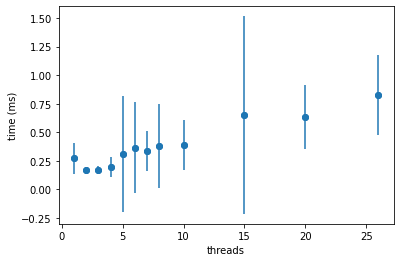

In [123]:
resultMaxParalelo = result
resultMaxParalelo = resultMaxParalelo.loc[resultMaxParalelo['algorithm'] == 'maximoParalelo']
time = resultMaxParalelo['time']['mean'].values.tolist()
std = resultMaxParalelo['time']['std'].values.tolist()
cantThreads = resultMaxParalelo['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

### Multithreading en cargar multiples archivos

In [70]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []
datasetsDir="./data/incremental/"

for repeat in tqdm(range(20)):
    for dataset in os.listdir(datasetsDir):
        #create output file
        result = './results/uniformeMultiplesArchivos.csv'
        outputFile = open(result, 'w+')
        outputFile.write("cantThreads,sec,ns,algorithm\n")

        args = ""
        for file in os.listdir(datasetsDir):
            args += " " + datasetsDir + file

        #print (args)
        for cantThreads in threads:
            command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
            p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
            p.wait()

            output=p.stdout.read().decode("utf-8")
            outputFile.write(output)

        outputFile.close()

        df = pd.read_csv(result, header=[0])
        dataframes.append(df)
    
dfExp2 = pd.concat(dataframes)
print(dfExp2)

100%|██████████| 10/10 [01:01<00:00,  6.13s/it]

    cantThreads  sec        ns                algorithm
0             1    0  20434152  cargarMultiplesArchivos
1             1    0    187774           maximoParalelo
2             2    0   9112952  cargarMultiplesArchivos
3             2    0    132043           maximoParalelo
4             3    0   9271430  cargarMultiplesArchivos
..          ...  ...       ...                      ...
19           15    0    361041           maximoParalelo
20           20    0   8667107  cargarMultiplesArchivos
21           20    0    522608           maximoParalelo
22           26    0   7503027  cargarMultiplesArchivos
23           26    0    662136           maximoParalelo

[7200 rows x 4 columns]


In [125]:
dfExp2['time'] = dfExp2.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp2 = dfExp2.drop(['sec', 'ns'], axis = 1)
result2 = dfExp2.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result2)

KeyError: 'sec'

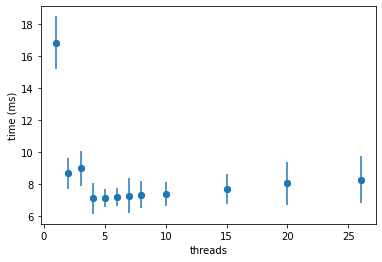

In [126]:
resultMultiArc = result2
resultMultiArc = resultMultiArc.loc[resultMultiArc['algorithm'] == 'cargarMultiplesArchivos']
time = resultMultiArc['time']['mean'].values.tolist()
std = resultMultiArc['time']['std'].values.tolist()
cantThreads = resultMultiArc['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

### Multithreading de maximo paralelo con distinta distribucion

In [121]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/normalRandomized.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/normalRandomized.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExpNorm = pd.concat(dataframes)
dfExpNorm['time'] = dfExpNorm.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExpNorm = dfExpNorm.drop(['sec', 'ns'], axis = 1)
resultNorm = dfExpNorm.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(resultNorm)

   cantThreads                algorithm       time           
                                              mean        std
0            1  cargarMultiplesArchivos  38.943483   6.255198
1            1           maximoParalelo   0.321472   0.109270
2            2  cargarMultiplesArchivos  37.434632   3.604227
3            2           maximoParalelo   0.194870   0.068221
4            3  cargarMultiplesArchivos  38.304002   4.484727
5            3           maximoParalelo   0.355832   0.493515
6            4  cargarMultiplesArchivos  37.411872   4.750323
7            4           maximoParalelo   0.321572   0.370873
8            5  cargarMultiplesArchivos  38.056621   6.189433
9            5           maximoParalelo   0.295013   0.281829
10           6  cargarMultiplesArchivos  37.818650   4.045291
11           6           maximoParalelo   0.782674   1.226823
12           7  cargarMultiplesArchivos  38.278444   5.807380
13           7           maximoParalelo   0.601817   1.206909
14      

In [120]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/bernoulliRandomized.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/bernoulliRandomized.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExpBer = pd.concat(dataframes)
dfExpBer['time'] = dfExpBer.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExpBer = dfExpBer.drop(['sec', 'ns'], axis = 1)
resultBer = dfExpBer.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(resultBer)

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  52.748464  6.921987
1            1           maximoParalelo   0.266718  0.062602
2            2  cargarMultiplesArchivos  50.768691  6.979138
3            2           maximoParalelo   0.435336  1.035522
4            3  cargarMultiplesArchivos  50.904548  6.826838
5            3           maximoParalelo   0.327250  0.348502
6            4  cargarMultiplesArchivos  48.993174  5.964595
7            4           maximoParalelo   0.223060  0.064317
8            5  cargarMultiplesArchivos  49.689569  7.258712
9            5           maximoParalelo   0.590084  0.888500
10           6  cargarMultiplesArchivos  48.596227  7.828245
11           6           maximoParalelo   0.343596  0.314598
12           7  cargarMultiplesArchivos  48.450916  6.746490
13           7           maximoParalelo   0.318740  0.235405
14           8  cargarMu

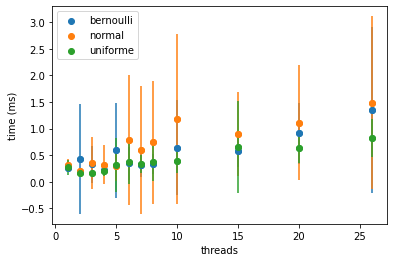

In [124]:
resultMaxParaleloBer = resultBer
resultMaxParaleloBer = resultMaxParaleloBer.loc[resultMaxParaleloBer['algorithm'] == 'maximoParalelo']
timeBer = resultMaxParaleloBer['time']['mean'].values.tolist()
stdBer = resultMaxParaleloBer['time']['std'].values.tolist()
cantThreadsBer = resultMaxParaleloBer['cantThreads'].values.tolist()

resultMaxParaleloNormal = resultNorm
resultMaxParaleloNormal = resultMaxParaleloNormal.loc[resultMaxParaleloNormal['algorithm'] == 'maximoParalelo']
timeNorm = resultMaxParaleloNormal['time']['mean'].values.tolist()
stdNorm = resultMaxParaleloNormal['time']['std'].values.tolist()
cantThreadsNorm = resultMaxParaleloNormal['cantThreads'].values.tolist()

plt.scatter(cantThreadsBer, timeBer, label = "bernoulli")
plt.errorbar(cantThreadsBer,timeBer, yerr = stdBer, fmt="o")

plt.scatter(cantThreadsNorm, timeNorm, label = "normal")
plt.errorbar(cantThreadsNorm,timeNorm, yerr = stdNorm, fmt="o")

plt.scatter(cantThreads, time, label = "uniforme")
plt.errorbar(cantThreads,time, yerr = std, fmt="o")

plt.legend(loc = "upper left")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

In [90]:
print(cantThreads)

26
